In [1]:
import sklearn

In [2]:
import os
os.environ['PATH'] = f"{os.environ['PATH']}:/root/.local/bin"

In [1]:
!python -m pip install --upgrade scikit-learn
import sklearn

# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [2]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 1000

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [3]:
# Load in the general demographics data.
dem_data = pd.read_csv("Udacity_AZDIAS_Subset.csv", sep=';')

# Load in the feature summary file.
features = pd.read_csv("AZDIAS_Feature_Summary.csv", sep=';')

In [ ]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

dem_rows, dem_cols = dem_data.shape

print('Demographic Data Rows: {}'.format(dem_rows))
print('Demographic Data Columns: {}\n'.format(dem_cols))

feat_rows, feat_cols = features.shape

print('Feature Summary Rows: {}'.format(feat_rows))
print('Feature Summary Columns: {}'.format(feat_cols))

In [ ]:
dem_data.head(10)

In [ ]:
dem_data.tail(10)

In [ ]:
features.head(25)

In [ ]:
dem_data.describe()

In [ ]:
features.describe()

In [ ]:
dem_data.info()

In [ ]:
features.info()

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [4]:
# Identify missing or unknown data values and convert them to NaNs.
# Create a helper function to build a list of the encoded data
def parse_encoded(missing_or_unknown):
    parse_list = list()
    for values in missing_or_unknown:
        parse_list.append(values[1:-1].split(","))
    return parse_list


encoded_list = parse_encoded(features["missing_or_unknown"])

In [ ]:
#Display the demographic data before replacing "missing_or_unknown" encoded values with np.nan
dem_data

In [5]:
# Using the encoded_list, replace data that matches a 'missing' or 'unknown' value code with a numpy NaN value

for attribute, encoded_value in zip(features['attribute'], encoded_list):
    if encoded_value[0] != "": #No need to check empty lists
        for value in encoded_value: #Check each encoding
            if value.isnumeric() or value.lstrip('-').isnumeric(): #Check for numeric values, both positive and negative
                value = int(value) #Cast from string value to int value
            #Where the value/attribute pair match, convert to np.nan
            dem_data.loc[dem_data[attribute] == value, attribute] = np.nan

In [ ]:
#Display the demographic data after replacing "missing_or_unknown" encoded values with np.nan
dem_data

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [6]:
# Perform an assessment of how much missing data there is in each column of the dataset.

col_nulls = dem_data.isnull().sum() #Sum up all null value counts per column

In [10]:
col_nulls.sort_values(ascending=False, inplace=True) #Sort, in place, descending
col_nulls.head(10)

TITEL_KZ          889061
AGER_TYP          685843
KK_KUNDENTYP      584612
KBA05_BAUMAX      476524
GEBURTSJAHR       392318
ALTER_HH          310267
KKK               158064
REGIOTYP          158064
W_KEIT_KIND_HH    147988
KBA05_ANTG3       133324
dtype: int64

In [11]:
# Investigate patterns in the amount of missing data in each column.
# Convert the raw number counts to a percentage to more easily visualize in a histogram
percent_col_nulls = col_nulls[col_nulls>0]/(len(dem_data))*100
percent_col_nulls.head(10)

TITEL_KZ          99.757636
AGER_TYP          76.955435
KK_KUNDENTYP      65.596749
KBA05_BAUMAX      53.468668
GEBURTSJAHR       44.020282
ALTER_HH          34.813699
KKK               17.735668
REGIOTYP          17.735668
W_KEIT_KIND_HH    16.605084
KBA05_ANTG3       14.959701
dtype: float64

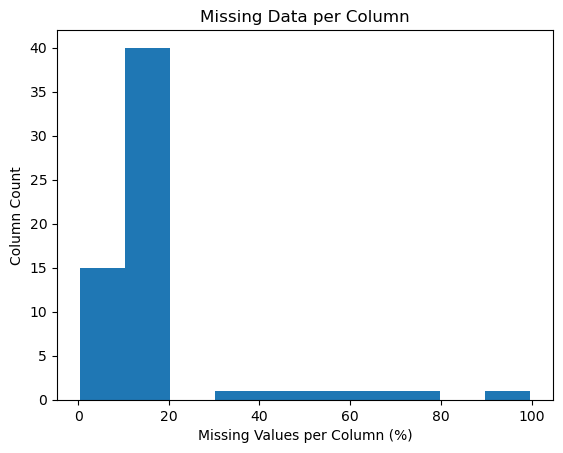

In [12]:
#Create a histogram to visualize the missing data per column
plt.hist(percent_col_nulls)
plt.xlabel('Missing Values per Column (%)')
plt.ylabel('Column Count')
plt.title('Missing Data per Column')
plt.show()

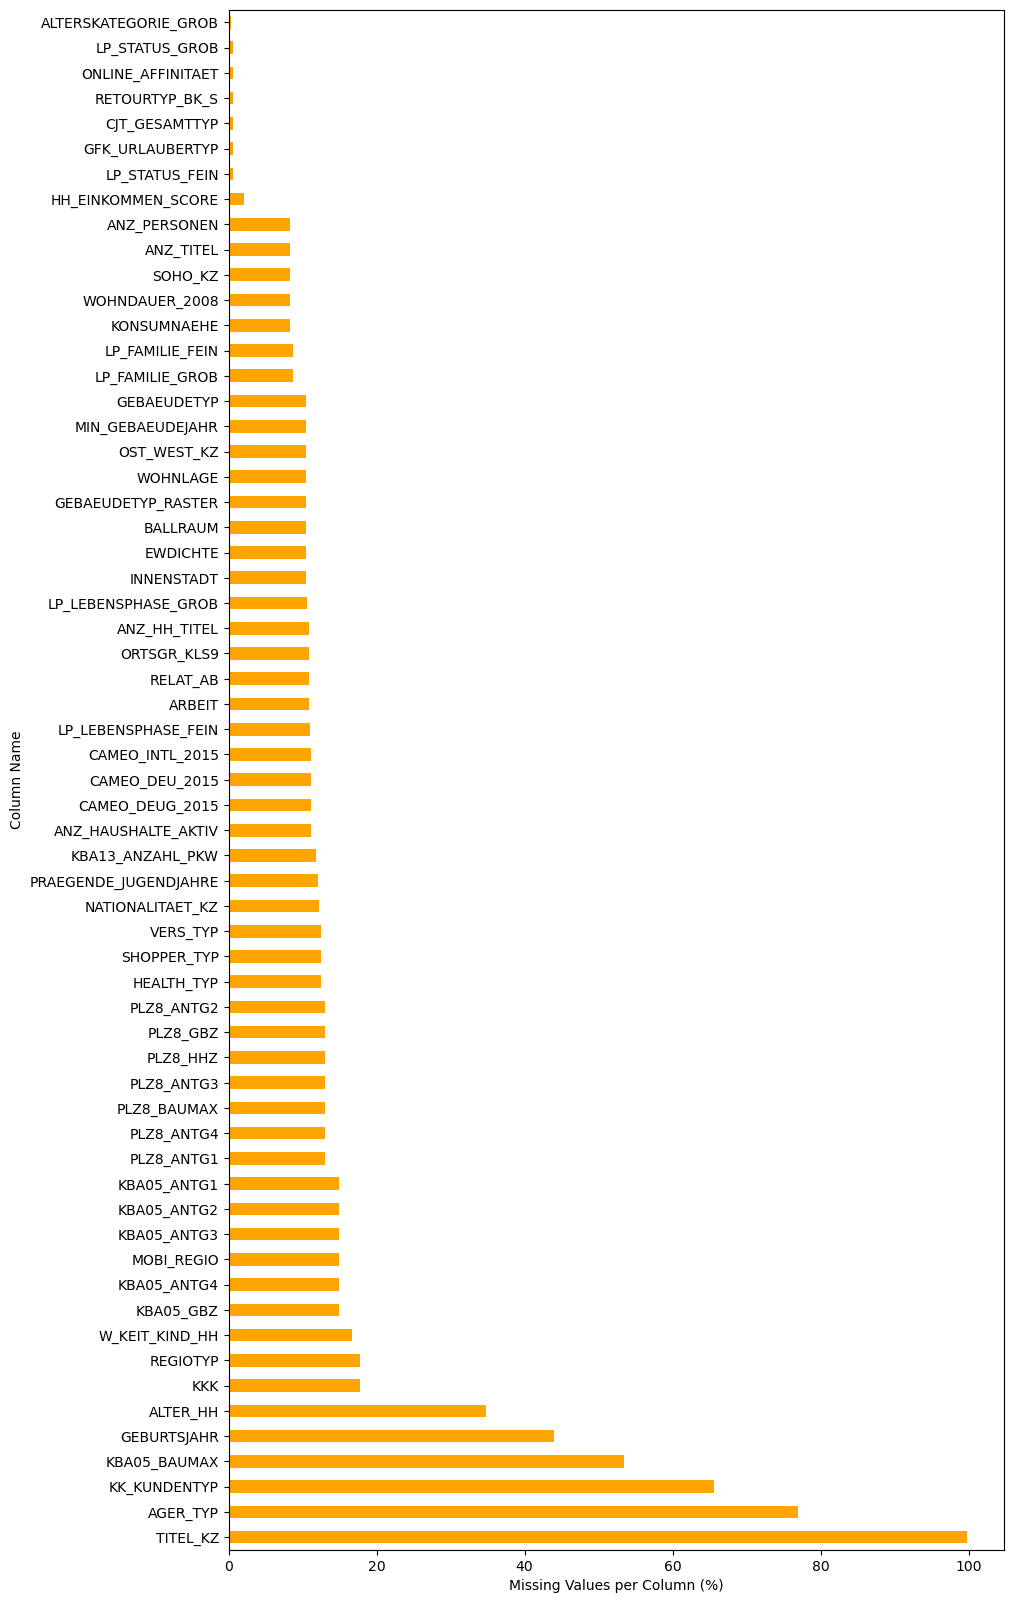

In [13]:
#Sort the missing values and plot in a horizontal chart by column
percent_col_nulls.sort_values(ascending=False, inplace=True)
percent_col_nulls.plot.barh(figsize=(10,20), color='orange')
plt.xlabel('Missing Values per Column (%)')
plt.ylabel('Column Name')

plt.show()

In [14]:
#There's a jump in missing data between "REGIOTYP" and "ALTER_HH", from 17.7% to 34.8% missing data, respectively.
#Setting the cutoff for outlier columns at greater than 18% missing data.

outliers = percent_col_nulls[percent_col_nulls>18].index

# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

dem_data1 = dem_data.copy()
dem_data1.drop(columns=outliers, axis="columns", inplace=True)

In [15]:
#Verify outlier columns removed
dem_data1.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1.0,2.0,3.0,4.0,3.0,5.0,5.0,3.0,4.0,10.0,0,NaN,15.0,4.0,2.0,2.0,1.0,1.0,NaN,NaN,5.0,2.0,6.0,7.0,5.0,1.0,5.0,3.0,3.0,4.0,7.0,6.0,6.0,5.0,3.0,NaN,NaN,NaN,3.0,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2.0,5.0,1.0,5.0,2.0,5.0,4.0,5.0,1.0,10.0,0,3.0,21.0,6.0,5.0,3.0,2.0,1.0,1.0,14.0,1.0,5.0,4.0,4.0,3.0,1.0,2.0,2.0,3.0,6.0,4.0,7.0,4.0,7.0,6.0,3.0,1.0,2.0,5.0,2.0,0.0,6.0,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2.0,3.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,10.0,1,3.0,3.0,1.0,1.0,1.0,3.0,2.0,1.0,15.0,3.0,4.0,1.0,3.0,3.0,4.0,4.0,6.0,3.0,4.0,7.0,7.0,7.0,3.0,3.0,2.0,0.0,1.0,5.0,1.0,0.0,4.0,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,6.0,1.0,0,2.0,NaN,NaN,NaN,NaN,9.0,4.0,1.0,8.0,2.0,5.0,1.0,2.0,1.0,4.0,4.0,7.0,4.0,3.0,4.0,4.0,5.0,4.0,4.0,1.0,0.0,1.0,3.0,0.0,0.0,1.0,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1.0,5.0,4.0,3.0,4.0,1.0,3.0,2.0,5.0,5.0,0,3.0,32.0,10.0,10.0,5.0,3.0,2.0,1.0,8.0,5.0,6.0,4.0,4.0,2.0,7.0,4.0,4.0,6.0,2.0,3.0,2.0,2.0,4.0,2.0,2.0,0.0,2.0,4.0,4.0,0.0,5.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [16]:
outliers

Index(['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR',
       'ALTER_HH'],
      dtype='object')

#### Discussion 1.1.2: Assess Missing Data in Each Column

Six columns were removed from the dataset due to the fact they were missing more than 30% of their data. Those columns were:

| Column Name  | Missing Data % |
| :----------- | :------------: |
| TITEL_KZ     | 99.757636
| AGER_TYP     | 76.955435
| KK_KUNDENTYP | 65.596749
| KBA05_BAUMAX | 53.468668
| GEBURTSJAHR  | 44.020282
| ALTER_HH     | 34.813699

I observed noticeable brackets of identical missing data percentages, particularly among those columns that are similarly named. For example:

**CAMEO Prefix (11.147852)**
* CAMEO_INTL_2015
* CAMEO_DEU_2015
* CAMEO_DEUG_2015

**PLZ8 Prefix (13.073637)**
* PLZ8_GBZ
* PLZ8_HHZ
* PLZ8_BAUMAX
* PLZ8_ANTG4
* PLZ8_ANTG1
* PLZ8_ANTG3
* PLZ8_ANTG2

**KBA05 Prefix (14.959701)**
* KBA05_ANTG2
* KBA05_ANTG1
* KBA05_ANTG3
* KBA05_GBZ
* KBA05_ANTG4

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [17]:
# How much data is missing in each row of the dataset?

row_nulls = dem_data1.isnull().sum(axis=1)

In [18]:
row_nulls.describe()

count    891221.000000
mean          5.649894
std          13.234687
min           0.000000
25%           0.000000
50%           0.000000
75%           3.000000
max          49.000000
dtype: float64

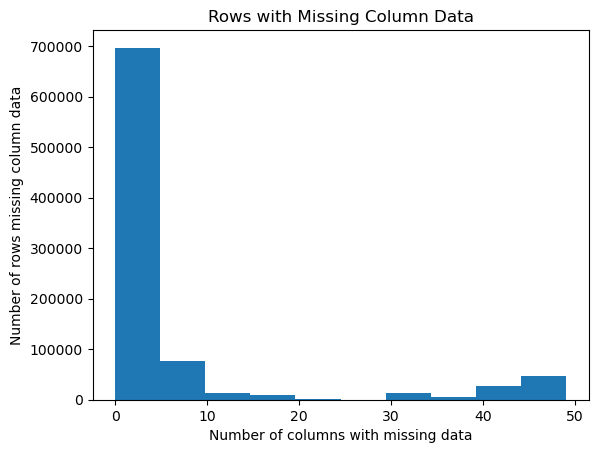

In [19]:
#First, create a histogram to visualize the distribution of missing row data per column
plt.hist(row_nulls)
plt.xlabel('Number of columns with missing data')
plt.ylabel('Number of rows missing column data')
plt.title('Rows with Missing Column Data')
plt.show()

In [20]:
# Write code to divide the data into two subsets based on the number of missing values in each row.
#Based on the histogram above, there are two clear groups:
#Group 1: Rows missing data in < 30 columns
lt_30 = dem_data1[row_nulls < 30]

#Group 2: Rows missing data in >= 30 columns
gte_30 = dem_data1[row_nulls >= 30]

#Display counts for each group
print("Group 1:", len(lt_30))
print("Group 2: ", len(gte_30))


Group 1: 798061
Group 2:  93160


In [373]:
#Create a helper function that plots side-by-side histograms, comparing columns, using countplot() and subplots()

def plots(col_name):
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    fig.set_figwidth(20)
    
    ax1.set_title("Less Than 30 Columns")
    sns.countplot(dem_data.loc[lt_30.index, col_name], ax=ax1)
    
    ax2.set_title("Greater or Equal to 30 Columns")
    sns.countplot(dem_data.loc[gte_30.index, col_name], ax=ax2)
    
    plt.show()

### Note For Reviewer
I've had a really hard time getting my plots() code to run offline (localhost via Anaconda). It's the exact same code I run in-browser online, yet throws a 'KeyError'.

I've been able to debug to the point where I think I need to reindex by two data sets (lt_30 and gte_30), but I'm not sure if that resolves the problem.

KeyError: 0

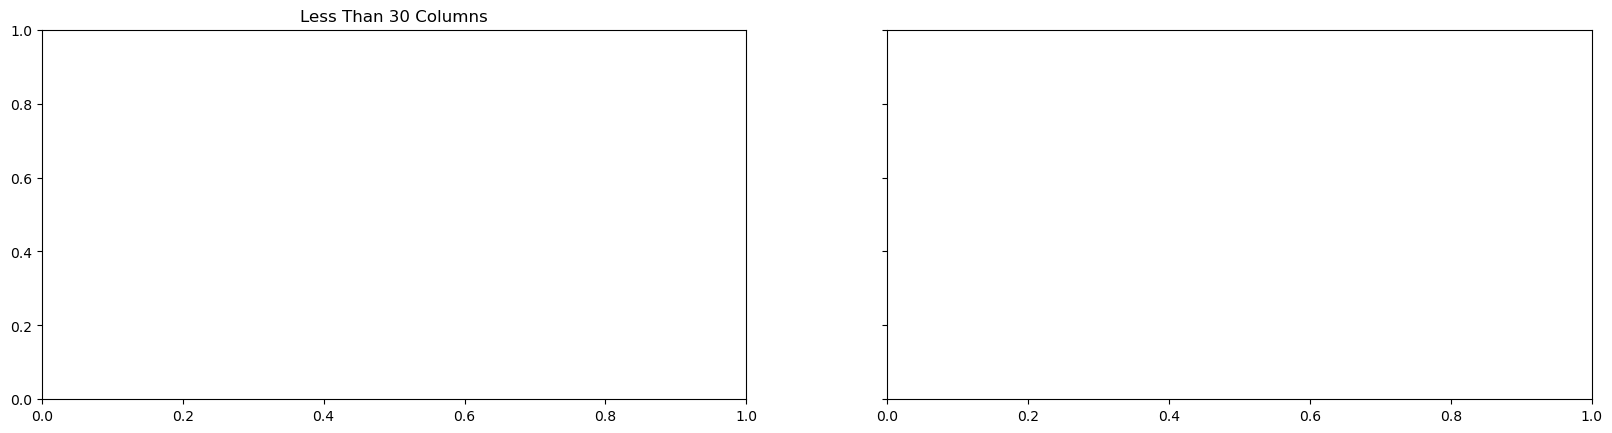

In [374]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

#Define a variable for those columns with no missing data
complete_cols = col_nulls[col_nulls==0].index

#Grab at least five of these columns for comparison, sorted by completeness (high-to-low)
top_cols = complete_cols[:5]

#Run top_cols through the plots() helper function, creating side-by-side histogram comparisons
for col_name in range(top_cols.size):
    plots(top_cols[col_name])


In [375]:
#Taking a look at the percentage of data that has missing column values for more than 30 columns
gte_30_percent = len(gte_30)/len(dem_data)*100
print(f'Number of rows missing 30 or more column values: {gte_30_percent:0.2f}%')

Number of rows missing 30 or more column values: 10.45%


# Discussion 1.1.3: Assess Missing Data in Each Row

I selected 5 columns for comparison that had no missing values. Rows were evaluated based on these columns and the results were compared in side-by-side bar graphs representing **two key groups**. The graphs on the left represent those rows where the referenced column had no missing values, and the rows were missing **fewer than 30 total values**. The graphs on the right represent those rows with the same referenced column, but missing **30 or more total values**.

There's a significant difference in distribution between the two key groups, with the >= 30 missing values group representing about 10.45% of our total data. I'm inclined to drop this group from the dataset due to the large amount of imputation required for 30 or more missing values. For the purposes of this assignment, dropping about 10.45% of the data seems an acceptable loss.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [25]:
#First drop the same columns from features that we dropped from the dem_data set
features = features.set_index('attribute').drop(outliers).reset_index()

In [26]:
# How many features are there of each data type?
features['type'].value_counts()

type
ordinal        49
categorical    18
mixed           6
numeric         6
Name: count, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [27]:
#Create a dictionary to track each data type identified in the previous section
type_dict = {} 
feature_types = ['ordinal', 'categorical', 'mixed', 'numeric']

for t in feature_types:
    type_dict[t] = features[features['type']==t]['attribute'] #Grab all attributes (column names) that match the feature type

In [28]:
#Check all the ordinal categorical values and ensure they're numeric. Leave alone if they are.
for col in lt_30[type_dict['ordinal']].columns:
    values = list(lt_30[col].unique())
    for v in values:
        if not isinstance(v, str) or np.isnan(v): #Ensuring values are not strings
            continue
        else:
            print(f'{v} in column {col} is not numeric.') #Print message if any strings are detected

In [29]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

#Take a look at each categorical column and break out those that are binary vs multi-level first
binary = []
multi = []

for col in lt_30[type_dict['categorical']].columns:
    values = lt_30[col].nunique()
    if values == 2:
        binary.append(col) #Build the binary list (2 categorical values)
    else:
        multi.append(col) #Build the multi-level list (3 or more categorical values)

In [30]:
#Based on the output above, inspect those binary categories' data
lt_30[binary].head()

,ANREDE_KZ,GREEN_AVANTGARDE,SOHO_KZ,VERS_TYP,OST_WEST_KZ
1,2.0,0,1.0,2.0,W
2,2.0,1,0.0,1.0,W
3,2.0,0,0.0,1.0,W
4,1.0,0,0.0,2.0,W
5,2.0,0,0.0,2.0,W


In [31]:
#Remove OST_WEST_KZ from the 'binary' array, to be handled later
binary.pop()
multi.append('OST_WEST_KZ')

In [32]:
lt_30[binary].head()

,ANREDE_KZ,GREEN_AVANTGARDE,SOHO_KZ,VERS_TYP
1,2.0,0,1.0,2.0
2,2.0,1,0.0,1.0
3,2.0,0,0.0,1.0
4,1.0,0,0.0,2.0
5,2.0,0,0.0,2.0


In [33]:
#Inspect the multi-level categories' data
lt_30[multi].head()

,CJT_GESAMTTYP,FINANZTYP,GFK_URLAUBERTYP,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,SHOPPER_TYP,ZABEOTYP,GEBAEUDETYP,CAMEO_DEUG_2015,CAMEO_DEU_2015,OST_WEST_KZ
1,5.0,1.0,10.0,5.0,3.0,2.0,1.0,1.0,3.0,5.0,8.0,8,8A,W
2,3.0,1.0,10.0,1.0,1.0,3.0,2.0,1.0,2.0,5.0,1.0,4,4C,W
3,2.0,6.0,1.0,NaN,NaN,9.0,4.0,1.0,1.0,3.0,1.0,2,2A,W
4,5.0,5.0,5.0,10.0,5.0,3.0,2.0,1.0,2.0,4.0,1.0,6,6B,W
5,2.0,2.0,1.0,1.0,1.0,4.0,2.0,1.0,0.0,4.0,1.0,8,8C,W


In [34]:
#Gather up the mixed categorical columns
mixed = []

for col in lt_30[type_dict['mixed']].columns:
    if col not in ['CAMEO_INTL_2015','PRAEGENDE_JUGENDJAHRE']:
        mixed.append(col)

In [35]:
lt_30[mixed].head()

,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,WOHNLAGE,PLZ8_BAUMAX
1,21.0,6.0,4.0,1.0
2,3.0,1.0,2.0,1.0
3,NaN,NaN,7.0,1.0
4,32.0,10.0,3.0,2.0
5,8.0,2.0,7.0,1.0


In [36]:
#Due to consistent kernel disconnects, I'm dropping those mixed columns that are not strictly required
#Should reduce the number of total attributes for imputing JUST the mixed columns from 101 to 36
for col in lt_30[type_dict['mixed']].columns:
    print(col, lt_30[type_dict['mixed']][col].nunique())

LP_LEBENSPHASE_FEIN 40
LP_LEBENSPHASE_GROB 12
PRAEGENDE_JUGENDJAHRE 15
WOHNLAGE 8
CAMEO_INTL_2015 21
PLZ8_BAUMAX 5


In [37]:
for col in lt_30[multi].columns:
    print(col, lt_30[multi][col].nunique())

CJT_GESAMTTYP 6
FINANZTYP 6
GFK_URLAUBERTYP 12
LP_FAMILIE_FEIN 11
LP_FAMILIE_GROB 5
LP_STATUS_FEIN 10
LP_STATUS_GROB 5
NATIONALITAET_KZ 3
SHOPPER_TYP 4
ZABEOTYP 6
GEBAEUDETYP 7
CAMEO_DEUG_2015 9
CAMEO_DEU_2015 44
OST_WEST_KZ 2


In [38]:
#In addition, I'm removing 'CAMEO_DEU_2015' to further reduce the number of columns I have to impute by 44
multi.remove('CAMEO_DEU_2015')
mixed.append('CAMEO_DEU_2015')

In [39]:
#Drop the mixed columns from features
features = features.set_index('attribute').drop(mixed).reset_index()

#Drop the mixed columns from lt_30 dataset
lt_30.drop(columns=mixed, axis="columns", inplace=True)

C:\Users\JeffHansberry.000\AppData\Local\Temp\ipykernel_12716\4022075733.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lt_30.drop(columns=mixed, axis="columns", inplace=True)


In [40]:
#Encode multi-level value columns
lt_30 = pd.get_dummies(lt_30, columns=multi)

In [41]:
lt_30.shape

(798061, 147)

In [42]:
lt_30.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,FINANZTYP_1.0,FINANZTYP_2.0,FINANZTYP_3.0,FINANZTYP_4.0,FINANZTYP_5.0,FINANZTYP_6.0,GFK_URLAUBERTYP_1.0,GFK_URLAUBERTYP_2.0,GFK_URLAUBERTYP_3.0,GFK_URLAUBERTYP_4.0,GFK_URLAUBERTYP_5.0,GFK_URLAUBERTYP_6.0,GFK_URLAUBERTYP_7.0,GFK_URLAUBERTYP_8.0,GFK_URLAUBERTYP_9.0,GFK_URLAUBERTYP_10.0,GFK_URLAUBERTYP_11.0,GFK_URLAUBERTYP_12.0,LP_FAMILIE_FEIN_1.0,LP_FAMILIE_FEIN_2.0,LP_FAMILIE_FEIN_3.0,LP_FAMILIE_FEIN_4.0,LP_FAMILIE_FEIN_5.0,LP_FAMILIE_FEIN_6.0,LP_FAMILIE_FEIN_7.0,LP_FAMILIE_FEIN_8.0,LP_FAMILIE_FEIN_9.0,LP_FAMILIE_FEIN_10.0,LP_FAMILIE_FEIN_11.0,LP_FAMILIE_GROB_1.0,LP_FAMILIE_GROB_2.0,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,LP_STATUS_FEIN_1.0,LP_STATUS_FEIN_2.0,LP_STATUS_FEIN_3.0,LP_STATUS_FEIN_4.0,LP_STATUS_FEIN_5.0,LP_STATUS_FEIN_6.0,LP_STATUS_FEIN_7.0,LP_STATUS_FEIN_8.0,LP_STATUS_FEIN_9.0,LP_STATUS_FEIN_10.0,LP_STATUS_GROB_1.0,LP_STATUS_GROB_2.0,LP_STATUS_GROB_3.0,LP_STATUS_GROB_4.0,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,ZABEOTYP_1.0,ZABEOTYP_2.0,ZABEOTYP_3.0,ZABEOTYP_4.0,ZABEOTYP_5.0,ZABEOTYP_6.0,GEBAEUDETYP_1.0,GEBAEUDETYP_2.0,GEBAEUDETYP_3.0,GEBAEUDETYP_4.0,GEBAEUDETYP_5.0,GEBAEUDETYP_6.0,GEBAEUDETYP_8.0,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,OST_WEST_KZ_O,OST_WEST_KZ_W
1,1.0,2.0,1.0,5.0,2.0,5.0,4.0,5.0,0,3.0,14.0,1.0,5.0,4.0,4.0,3.0,1.0,2.0,2.0,3.0,6.0,4.0,7.0,4.0,7.0,6.0,1.0,2.0,2.0,0.0,6.0,3.0,9.0,11.0,0.0,1.0,1992.0,51,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,5.0,4.0,3.0,5.0,4.0,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,True
2,3.0,2.0,1.0,4.0,1.0,2.0,3.0,5.0,1,3.0,15.0,3.0,4.0,1.0,3.0,3.0,4.0,4.0,6.0,3.0,4.0,7.0,7.0,7.0,3.0,3.0,0.0,1.0,1.0,0.0,4.0,3.0,9.0,10.0,0.0,5.0,1992.0,24,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,4.0,4.0,3.0,5.0,2.0,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,True,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True
3,4.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,0,2.0,8.0,2.0,5.0,1.0,2.0,1.0,4.0,4.0,7.0,4.0,3.0,4.0,4.0,5.0,4.0,4.0,0.0,1.0,0.0,0.0,1.0,NaN,9.0,1.0,0.0,4.0,1997.0,12,4.0,1.0,0.0,0.0,4

#### Discussion 1.2.1: Re-Encode Categorical Features

##### Categorical Feature Encoding
* **Ordinal**: Verified the existing ordinal values did not contain strings and were either numeric or nan values.
    * No data changes were required.
* **Multi-Level**: Brought over the 'OST_WEST_KZ' binary categorical feature to the multi-level features, to be re-encoded as part of the dummy process.
    * All multi-level features successfully encoded.
* **Binary**: Verified existing binary categorical data is numeric with the exception of 'OST_WEST_KZ'.
    * 'OST_WEST_KZ' moved to multi-level features and encoded.
* Dropped features as identified in comments above, in addition to these six identified previously as having too many values missing per row:
    * 'TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR', 'ALTER_HH'

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

#### PRAEGENDE_JUGENDJAHRE Mapping
I'm listing the current mapping here for quick reference:

Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
-  1: 40s - war years (Mainstream, E+W)
-  2: 40s - reconstruction years (Avantgarde, E+W)
-  3: 50s - economic miracle (Mainstream, E+W)
-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
-  5: 60s - economic miracle (Mainstream, E+W)
-  6: 60s - generation 68 / student protestors (Avantgarde, W)
-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
-  8: 70s - family orientation (Mainstream, E+W)
-  9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)

In [43]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

# We know which decades correspond to which encodings. Replacing the current encodings with the decade-specific encodings
# Movements will be binary [0,1] based on Mainstream (0) and Avantgarde(1)

decade = []
movement = []

for value in lt_30['PRAEGENDE_JUGENDJAHRE']:
    #Re-encode decade
    if value in [1,2]: #All instances of 40's
        decade.append(40)
    elif value in [3,4]: #All instances of 50's
        decade.append(50)
    elif value in [5,6,7]: #All instances of 60's
        decade.append(60)
    elif value in [8,9]: #All isntances of 70's
        decade.append(70)
    elif value in [10,11,12,13]: #All instances of 80's
        decade.append(80)
    elif value in [14,15]: #All instances of 90's
        decade.append(90)
    else:
        decade.append(np.NaN) #Catch empty values
    #Re-encode movement
    if value in [1,3,5,8,10,12,14]: #All instances of 'Mainstream'
        movement.append(0) 
    elif value in [2,4,6,7,9,11,13,15]: #All instances of "Avantgarde"
        movement.append(1)
    else:
        movement.append(np.NaN) #Catch empty values

In [44]:
#Convert decade and movement to Series to add to the lt_30 DF later
decade = pd.Series(decade)
movement = pd.Series(movement)

In [45]:
#Add newly created columns and data to lt_30 DF
lt_30['decade'] = decade
lt_30['movement'] = movement

#Drop 'PRAEGENDE_JUGENDJAHRE' from the lt_30 DF
lt_30.drop(['PRAEGENDE_JUGENDJAHRE'], axis=1, inplace=True)

In [46]:
lt_30.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,FINANZTYP_1.0,FINANZTYP_2.0,FINANZTYP_3.0,FINANZTYP_4.0,FINANZTYP_5.0,FINANZTYP_6.0,GFK_URLAUBERTYP_1.0,GFK_URLAUBERTYP_2.0,GFK_URLAUBERTYP_3.0,GFK_URLAUBERTYP_4.0,GFK_URLAUBERTYP_5.0,GFK_URLAUBERTYP_6.0,GFK_URLAUBERTYP_7.0,GFK_URLAUBERTYP_8.0,GFK_URLAUBERTYP_9.0,GFK_URLAUBERTYP_10.0,GFK_URLAUBERTYP_11.0,GFK_URLAUBERTYP_12.0,LP_FAMILIE_FEIN_1.0,LP_FAMILIE_FEIN_2.0,LP_FAMILIE_FEIN_3.0,LP_FAMILIE_FEIN_4.0,LP_FAMILIE_FEIN_5.0,LP_FAMILIE_FEIN_6.0,LP_FAMILIE_FEIN_7.0,LP_FAMILIE_FEIN_8.0,LP_FAMILIE_FEIN_9.0,LP_FAMILIE_FEIN_10.0,LP_FAMILIE_FEIN_11.0,LP_FAMILIE_GROB_1.0,LP_FAMILIE_GROB_2.0,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,LP_STATUS_FEIN_1.0,LP_STATUS_FEIN_2.0,LP_STATUS_FEIN_3.0,LP_STATUS_FEIN_4.0,LP_STATUS_FEIN_5.0,LP_STATUS_FEIN_6.0,LP_STATUS_FEIN_7.0,LP_STATUS_FEIN_8.0,LP_STATUS_FEIN_9.0,LP_STATUS_FEIN_10.0,LP_STATUS_GROB_1.0,LP_STATUS_GROB_2.0,LP_STATUS_GROB_3.0,LP_STATUS_GROB_4.0,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,ZABEOTYP_1.0,ZABEOTYP_2.0,ZABEOTYP_3.0,ZABEOTYP_4.0,ZABEOTYP_5.0,ZABEOTYP_6.0,GEBAEUDETYP_1.0,GEBAEUDETYP_2.0,GEBAEUDETYP_3.0,GEBAEUDETYP_4.0,GEBAEUDETYP_5.0,GEBAEUDETYP_6.0,GEBAEUDETYP_8.0,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,OST_WEST_KZ_O,OST_WEST_KZ_W,decade,movement
1,1.0,2.0,1.0,5.0,2.0,5.0,4.0,5.0,0,3.0,1.0,5.0,4.0,4.0,3.0,1.0,2.0,2.0,3.0,6.0,4.0,7.0,4.0,7.0,6.0,1.0,2.0,2.0,0.0,6.0,3.0,9.0,11.0,0.0,1.0,1992.0,51,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,5.0,4.0,3.0,5.0,4.0,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,True,90.0,1.0
2,3.0,2.0,1.0,4.0,1.0,2.0,3.0,5.0,1,3.0,3.0,4.0,1.0,3.0,3.0,4.0,4.0,6.0,3.0,4.0,7.0,7.0,7.0,3.0,3.0,0.0,1.0,1.0,0.0,4.0,3.0,9.0,10.0,0.0,5.0,1992.0,24,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,4.0,4.0,3.0,5.0,2.0,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,True,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,70.0,0.0
3,4.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,0,2.0,2.0,5.0,1.0,2.0,1.0,4.0,4.0,7.0,4.0,3.0,4.0,4.0,5.0,4.0,4.0,0.0,1.0,0.0,0.0,1.0,NaN,9.0,1.0,0.0,4.0,1997.0,12,4.0,1.0,0.0,0.0,4.0

#### CAMEO_INTL_2015 Mapping
I'm listing the current mapping here for quick reference:

German CAMEO: Wealth / Life Stage Typology, mapped to international code
- 11: Wealthy Households - Pre-Family Couples & Singles
- 12: Wealthy Households - Young Couples With Children
- 13: Wealthy Households - Families With School Age Children
- 14: Wealthy Households - Older Families &  Mature Couples
- 15: Wealthy Households - Elders In Retirement
- 21: Prosperous Households - Pre-Family Couples & Singles
- 22: Prosperous Households - Young Couples With Children
- 23: Prosperous Households - Families With School Age Children
- 24: Prosperous Households - Older Families & Mature Couples
- 25: Prosperous Households - Elders In Retirement
- 31: Comfortable Households - Pre-Family Couples & Singles
- 32: Comfortable Households - Young Couples With Children
- 33: Comfortable Households - Families With School Age Children
- 34: Comfortable Households - Older Families & Mature Couples
- 35: Comfortable Households - Elders In Retirement
- 41: Less Affluent Households - Pre-Family Couples & Singles
- 42: Less Affluent Households - Young Couples With Children
- 43: Less Affluent Households - Families With School Age Children
- 44: Less Affluent Households - Older Families & Mature Couples
- 45: Less Affluent Households - Elders In Retirement
- 51: Poorer Households - Pre-Family Couples & Singles
- 52: Poorer Households - Young Couples With Children
- 53: Poorer Households - Families With School Age Children
- 54: Poorer Households - Older Families & Mature Couples
- 55: Poorer Households - Elders In Retirement

In [47]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

#Verify the data type for 'CAMEO_INTL_2015' data.
type(lt_30['CAMEO_INTL_2015'][1])

str

In [48]:
#With the values being strings, I can parse them via indexing and cast each digit as an int()
#Index[0] = Wealth encoding
#Index[1] = Life Stage encoding

wealth = []
life_stage = []

for value in lt_30['CAMEO_INTL_2015']:
    if isinstance(value, str): #Verify the value isn't np.nan, then parse and append accordingly to each sub array
        wealth.append(int(value[0]))
        life_stage.append(int(value[1]))
    else: #Catch np.nan values and append accordingly to each sub array
        wealth.append(np.nan)
        life_stage.append(np.nan)

In [49]:
#Convert wealth and life_stage to Series to add to the lt_30 DF later
wealth = pd.Series(wealth)
life_stage = pd.Series(life_stage)

In [50]:
#Add newly created columns and data to lt_30 DF
lt_30['wealth'] = wealth
lt_30['life_stage'] = life_stage

#Drop 'CAMEO_INTL_2015' from the lt_30 DF
lt_30.drop(['CAMEO_INTL_2015'], axis=1, inplace=True)

In [51]:
lt_30.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,FINANZTYP_1.0,FINANZTYP_2.0,FINANZTYP_3.0,FINANZTYP_4.0,FINANZTYP_5.0,FINANZTYP_6.0,GFK_URLAUBERTYP_1.0,GFK_URLAUBERTYP_2.0,GFK_URLAUBERTYP_3.0,GFK_URLAUBERTYP_4.0,GFK_URLAUBERTYP_5.0,GFK_URLAUBERTYP_6.0,GFK_URLAUBERTYP_7.0,GFK_URLAUBERTYP_8.0,GFK_URLAUBERTYP_9.0,GFK_URLAUBERTYP_10.0,GFK_URLAUBERTYP_11.0,GFK_URLAUBERTYP_12.0,LP_FAMILIE_FEIN_1.0,LP_FAMILIE_FEIN_2.0,LP_FAMILIE_FEIN_3.0,LP_FAMILIE_FEIN_4.0,LP_FAMILIE_FEIN_5.0,LP_FAMILIE_FEIN_6.0,LP_FAMILIE_FEIN_7.0,LP_FAMILIE_FEIN_8.0,LP_FAMILIE_FEIN_9.0,LP_FAMILIE_FEIN_10.0,LP_FAMILIE_FEIN_11.0,LP_FAMILIE_GROB_1.0,LP_FAMILIE_GROB_2.0,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,LP_STATUS_FEIN_1.0,LP_STATUS_FEIN_2.0,LP_STATUS_FEIN_3.0,LP_STATUS_FEIN_4.0,LP_STATUS_FEIN_5.0,LP_STATUS_FEIN_6.0,LP_STATUS_FEIN_7.0,LP_STATUS_FEIN_8.0,LP_STATUS_FEIN_9.0,LP_STATUS_FEIN_10.0,LP_STATUS_GROB_1.0,LP_STATUS_GROB_2.0,LP_STATUS_GROB_3.0,LP_STATUS_GROB_4.0,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,ZABEOTYP_1.0,ZABEOTYP_2.0,ZABEOTYP_3.0,ZABEOTYP_4.0,ZABEOTYP_5.0,ZABEOTYP_6.0,GEBAEUDETYP_1.0,GEBAEUDETYP_2.0,GEBAEUDETYP_3.0,GEBAEUDETYP_4.0,GEBAEUDETYP_5.0,GEBAEUDETYP_6.0,GEBAEUDETYP_8.0,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,OST_WEST_KZ_O,OST_WEST_KZ_W,decade,movement,wealth,life_stage
1,1.0,2.0,1.0,5.0,2.0,5.0,4.0,5.0,0,3.0,1.0,5.0,4.0,4.0,3.0,1.0,2.0,2.0,3.0,6.0,4.0,7.0,4.0,7.0,6.0,1.0,2.0,2.0,0.0,6.0,3.0,9.0,11.0,0.0,1.0,1992.0,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,5.0,4.0,3.0,5.0,4.0,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,True,90.0,1.0,2.0,4.0
2,3.0,2.0,1.0,4.0,1.0,2.0,3.0,5.0,1,3.0,3.0,4.0,1.0,3.0,3.0,4.0,4.0,6.0,3.0,4.0,7.0,7.0,7.0,3.0,3.0,0.0,1.0,1.0,0.0,4.0,3.0,9.0,10.0,0.0,5.0,1992.0,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,4.0,4.0,3.0,5.0,2.0,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,True,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,70.0,0.0,1.0,2.0
3,4.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,0,2.0,2.0,5.0,1.0,2.0,1.0,4.0,4.0,7.0,4.0,3.0,4.0,4.0,5.0,4.0,4.0,0.0,1.0,0.0,0.0,1.0,NaN,9.0,1.0,0.0,4.0,1997.0,4.0,1.0,0.

In [52]:
lt_30.shape

(798061, 149)

#### Discussion 1.2.2: Engineer Mixed-Type Features

##### Mixed Feature Encoding
* Dropped six features identified previously as having too many values missing per row:
    * 'TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR', 'ALTER_HH'
* Dropped four additional mixed features to reduce Kernel load due to too many dummy categories:
    * 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'WOHNLAGE', 'PLZ8_BAUMAX'
* For **'CAMEO_INTL_2015'**, I created two new columns, **wealth** and **life_stage**
    * Mapped wealth based on the tens position, i.e. **5**2.
    * Mapped life_stage based on the ones position, i.e. 5**2**
* For **'PRAEGENDE_JUGENDJAHRE'**, I created two new columns, **decade** and **movement**
    * Mapped movement as binary [0,1] based on Mainstream (0) and Avantgarde(1)
    * Mapped decade based on the Data_Dictionary.md mapping

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

##### I'm satisified with my data and feature selection at this stage.

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [53]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # Load in the feature summary file.
    feat = pd.read_csv("AZDIAS_Feature_Summary.csv", sep=';')
    # Create a helper function to build a list of the encoded data
    def parse_encoded(missing_or_unknown):
        parse_list = list()
        for values in missing_or_unknown:
            parse_list.append(values[1:-1].split(","))
        return parse_list

    encoded_list = parse_encoded(feat["missing_or_unknown"])
    
    # convert missing value codes into NaNs, ...
    for attribute, encoded_value in zip(feat['attribute'], encoded_list):
        if encoded_value[0] != "": #No need to check empty lists
            for value in encoded_value: #Check each encoding
                if value.isnumeric() or value.lstrip('-').isnumeric(): #Check for numeric values, both positive and negative
                    value = int(value) #Cast from string value to int value
                #Where the value/attribute pair match, convert to np.nan
                df.loc[df[attribute] == value, attribute] = np.nan
    
    # remove selected columns and rows, ...
    #drop outlier columns
    outliers = ['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR', 'ALTER_HH']
    df.drop(columns=outliers, axis="columns", inplace=True)
    feat = feat.set_index('attribute').drop(outliers).reset_index()
    
    #Trim rows
    row_nulls = df.isnull().sum(axis=1)
    df = df[row_nulls < 30]
    
    # select, re-encode, and engineer column values.
    #Create a dictionary to track each data type identified in the previous section
    type_dict = {} 
    feature_types = ['ordinal', 'categorical', 'mixed', 'numeric']

    for t in feature_types:
        #Grab all attributes (column names) that match the feature type
        type_dict[t] = feat[feat['type']==t]['attribute']
        
    #Check all the ordinal categorical values and ensure they're numeric. Leave alone if they are.
    for col in df[type_dict['ordinal']].columns:
        values = list(df[col].unique())
        for v in values:
            if not isinstance(v, str) or np.isnan(v): #Ensuring values are not strings
                continue
            else:
                print(f'{v} in column {col} is not numeric.') #Print message if any strings are detected
                
    #Take a look at each categorical column and break out those that are binary vs multi-level first
    binary = []
    multi = []

    for col in df[type_dict['categorical']].columns:
        values = df[col].nunique()
        if values == 2:
            binary.append(col) #Build the binary list (2 categorical values)
        else:
            multi.append(col) #Build the multi-level list (3 or more categorical values)
            
    #Remove OST_WEST_KZ from the 'binary' array and append to the 'multi' array, to be handled as part of that step
    binary.pop(1)
    multi.append('OST_WEST_KZ')
    
    #Gather up the mixed categorical columns
    mixed = []

    for col in df[type_dict['mixed']].columns:
        if col not in ['CAMEO_INTL_2015','PRAEGENDE_JUGENDJAHRE']:
            mixed.append(col)
    
    #In addition, I'm removing 'CAMEO_DEU_2015' to further reduce the number of columns I have to impute by 44
    multi.remove('CAMEO_DEU_2015')
    mixed.append('CAMEO_DEU_2015')
    
    #Drop the mixed columns from features
    feat = feat.set_index('attribute').drop(mixed).reset_index()

    #Drop the mixed columns from df dataset
    df.drop(columns=mixed, axis="columns", inplace=True)

    #Encode multi-level value columns
    df = pd.get_dummies(df, columns=multi)
    
    # Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
    # We know which decades correspond to which encodings. Replacing the current encodings with the decade-specific encodings
    # Movements will be binary [0,1] based on Mainstream (0) and Avantgarde(1)

    decade = []
    movement = []

    for value in df['PRAEGENDE_JUGENDJAHRE']:
        #Re-encode decade
        if value in [1,2]: #All instances of 40's
            decade.append(40)
        elif value in [3,4]: #All instances of 50's
            decade.append(50)
        elif value in [5,6,7]: #All instances of 60's
            decade.append(60)
        elif value in [8,9]: #All isntances of 70's
            decade.append(70)
        elif value in [10,11,12,13]: #All instances of 80's
            decade.append(80)
        elif value in [14,15]: #All instances of 90's
            decade.append(90)
        else:
            decade.append(np.NaN) #Catch empty values
        #Re-encode movement
        if value in [1,3,5,8,10,12,14]: #All instances of 'Mainstream'
            movement.append(0) 
        elif value in [2,4,6,7,9,11,13,15]: #All instances of "Avantgarde"
            movement.append(1)
        else:
            movement.append(np.NaN) #Catch empty values
            
    #Convert decade and movement to Series to add to df later
    decade = pd.Series(decade)
    movement = pd.Series(movement)
    
    #Add newly created columns and data to df
    df['decade'] = decade
    df['movement'] = movement

    #Drop 'PRAEGENDE_JUGENDJAHRE' from df
    df.drop(['PRAEGENDE_JUGENDJAHRE'], axis=1, inplace=True)
    
    #With the values being strings, I can parse them via indexing and cast each digit as an int()
    #Index[0] = Wealth encoding
    #Index[1] = Life Stage encoding

    wealth = []
    life_stage = []

    for value in df['CAMEO_INTL_2015']:
        if isinstance(value, str): #Verify the value isn't np.nan, then parse and append accordingly to each sub array
            wealth.append(int(value[0]))
            life_stage.append(int(value[1]))
        else: #Catch np.nan values and append accordingly to each sub array
            wealth.append(np.nan)
            life_stage.append(np.nan)
            
    #Convert wealth and life_stage to Series to add to df later
    wealth = pd.Series(wealth)
    life_stage = pd.Series(life_stage)     
    
    #Add newly created columns and data to df
    df['wealth'] = wealth
    df['life_stage'] = life_stage

    #Drop 'CAMEO_INTL_2015' from df
    df.drop(['CAMEO_INTL_2015'], axis=1, inplace=True)
    
    # Return the cleaned dataframe.    
    return df

Taking a moment to run a test df copy through the clean_data() function. If all goes as it should, the test df and lt_30 df will match shape.

In [54]:
test_run_df = dem_data.copy()

In [55]:
test_run_df = clean_data(test_run_df)

C:\Users\JeffHansberry.000\AppData\Local\Temp\ipykernel_12716\945778120.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=mixed, axis="columns", inplace=True)


In [56]:
lt_30.shape == test_run_df.shape

True

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [57]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and do that now.
#Check for current np.nan values in our dataset (lt_30)
lt_30.isnull().sum().sum()

1090825

In [59]:
#Use imputation to clear these np.nan values
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy="median", copy = False)

In [60]:
#Impute values
lt_30_imputed = imputer.fit_transform(lt_30)

In [117]:
#Check for current np.nan values post-imputation
#First, convert lt_30_imputed back into a DataFrame for ease of use
#Create a list of lt_30 column names to use when converting its ndarray type back to DataFrame
lt_30_cols = list(lt_30.columns.values)

#Pass the lt_30_imputed as 'data', and lt_30_cols as 'columns'
lt_30_imputed_df = pd.DataFrame(data=lt_30_imputed, columns=lt_30_cols)

#Now that we have a DataFrame again, check for post-imputation null values
lt_30_imputed_df.isnull().sum().sum()

0

In [89]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()
scaled_features = scaler.fit_transform(lt_30_imputed_df)

In [103]:
#Convert scaled_features to a DataFrame for ease of use
scaled_features_df = pd.DataFrame(data=scaled_features, columns=lt_30_cols)

In [127]:
scaled_features_df.head(15)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,FINANZTYP_1.0,FINANZTYP_2.0,FINANZTYP_3.0,FINANZTYP_4.0,FINANZTYP_5.0,FINANZTYP_6.0,GFK_URLAUBERTYP_1.0,GFK_URLAUBERTYP_2.0,GFK_URLAUBERTYP_3.0,GFK_URLAUBERTYP_4.0,GFK_URLAUBERTYP_5.0,GFK_URLAUBERTYP_6.0,GFK_URLAUBERTYP_7.0,GFK_URLAUBERTYP_8.0,GFK_URLAUBERTYP_9.0,GFK_URLAUBERTYP_10.0,GFK_URLAUBERTYP_11.0,GFK_URLAUBERTYP_12.0,LP_FAMILIE_FEIN_1.0,LP_FAMILIE_FEIN_2.0,LP_FAMILIE_FEIN_3.0,LP_FAMILIE_FEIN_4.0,LP_FAMILIE_FEIN_5.0,LP_FAMILIE_FEIN_6.0,LP_FAMILIE_FEIN_7.0,LP_FAMILIE_FEIN_8.0,LP_FAMILIE_FEIN_9.0,LP_FAMILIE_FEIN_10.0,LP_FAMILIE_FEIN_11.0,LP_FAMILIE_GROB_1.0,LP_FAMILIE_GROB_2.0,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,LP_STATUS_FEIN_1.0,LP_STATUS_FEIN_2.0,LP_STATUS_FEIN_3.0,LP_STATUS_FEIN_4.0,LP_STATUS_FEIN_5.0,LP_STATUS_FEIN_6.0,LP_STATUS_FEIN_7.0,LP_STATUS_FEIN_8.0,LP_STATUS_FEIN_9.0,LP_STATUS_FEIN_10.0,LP_STATUS_GROB_1.0,LP_STATUS_GROB_2.0,LP_STATUS_GROB_3.0,LP_STATUS_GROB_4.0,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,ZABEOTYP_1.0,ZABEOTYP_2.0,ZABEOTYP_3.0,ZABEOTYP_4.0,ZABEOTYP_5.0,ZABEOTYP_6.0,GEBAEUDETYP_1.0,GEBAEUDETYP_2.0,GEBAEUDETYP_3.0,GEBAEUDETYP_4.0,GEBAEUDETYP_5.0,GEBAEUDETYP_6.0,GEBAEUDETYP_8.0,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,OST_WEST_KZ_O,OST_WEST_KZ_W,decade,movement,wealth,life_stage
0,-1.766646,0.957914,-1.494594,1.537924,-1.040692,1.465965,0.958645,1.339314,-0.530409,1.096612,-1.686342,0.443199,-0.059352,0.002844,-0.463904,-1.684514,-1.109907,-1.435376,-0.578167,1.274182,-0.312190,1.339259,-0.157562,1.518695,1.288982,10.854129,0.922944,0.234451,-0.060408,1.026714,-0.671568,0.567325,0.171648,-0.125134,-1.304747,-0.383170,-1.070652,-1.030778,-0.594877,2.730663,-1.659268,0.845768,-0.546591,1.701104,-0.799737,-0.791625,-1.411416,0.171117,-0.857881,1.020663,-0.256529,0.211982,0.402979,0.406609,1.430456,0.574305,-0.166388,-0.127041,0.684882,-0.363872,-0.463777,-0.475604,-0.574996,2.486436,-0.383034,1.745726,-0.388748,-0.243880,-0.274504,-0.392070,-0.753591,-0.260346,-0.241143,-0.266984,-0.286204,-0.311289,-0.182556,-0.23176,-0.340765,-0.277682,2.600173,-0.322309,-0.441656,-1.008875,-0.375356,-0.07687,-0.12131,8.394404,-0.103917,-0.158572,-0.167502,-0.115198,-0.439046,-0.255057,-1.008875,-0.375356,5.300521,-0.258205,-0.555459,-0.591508,2.486384,-0.30744,-0.319625,-0.189240,-0.193825,-0.108016,-0.155472,-0.453941,-0.403149,1.228761,-0.521203,-0.223907,-0.491322,-0.403149,0.441399,-0.294397,-0.206255,-0.435292,-0.670308,-0.589735,1.847287,-0.427793,-0.207703,-0.739707,-0.592817,2.976110,-0.312172,-1.167869,-0.078857,-0.537078,-0.033601,-0.001119,-0.028063,2.057688,-0.218018,-0.341223,-0.349283,-0.386905,-0.272883,-0.391096,-0.328970,2.221743,-0.395986,-0.517426,0.517426,1.261170,2.021661,-0.960271,0.795445
1,0.200522,0.957914,-1.494594,0.864563,-1.766980,-0.570998,0.244119,1.339314,1.885336,1.096612,-0.307717,-0.072018,-1.626988,-0.520579,-0.463904,-0.142556,-0.158738,0.754258,-0.578167,0.064234,1.392000,1.339259,1.448744,-0.638939,-0.4102

### Discussion 2.1: Apply Feature Scaling

I first replaced all existing np.nan values with imputed values using the 'Mean' method. Once imputing was complete, I used the StandardScaler to apply feature scaling to the entire dataset.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [128]:
# Apply PCA to the data.
pca = PCA()

In [149]:
#Iterate over a selection of component totals to figure out which gets us over 85% explained variance
num_components = [60, 65, 70, 75, 80, 100]
for comp in num_components:
    pca = PCA(comp)
    X_pca = pca.fit_transform(scaled_features_df)
    if pca.explained_variance_ratio_.sum() >= .85: #Define our explained variance value here
        break #Found our PC count, so break from the loop
print(f'Explained Variance Ratio: {pca.explained_variance_ratio_.sum()}')
print(f'Number of Components: {pca.n_components}')

Explained Variance Ratio: 0.8774640024915715
Number of Components: 75


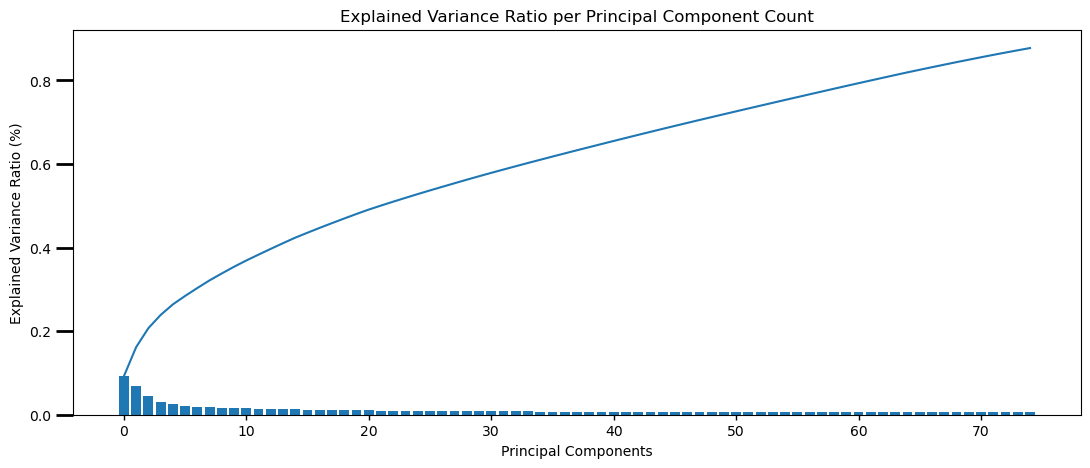

In [378]:
# Investigate the variance accounted for by each principal component.
#Create a bar graph and line graph representing PC individual ratios and cumulative PC ratio totals
ticks = np.arange(pca.n_components)
e_v_r = pca.explained_variance_ratio_

plt.figure(figsize = (13,5))
ax = plt.subplot()
cumvals = np.cumsum(e_v_r) #Generate line graph values for cumulative principal component totals
ax.bar(ticks,e_v_r)
ax.plot(ticks,cumvals)

ax.xaxis.set_tick_params(width=1)
ax.yaxis.set_tick_params(width=2,length=12)

ax.set_xlabel("Principal Components")
ax.set_ylabel("Explained Variance Ratio (%)")
plt.title('Explained Variance Ratio per Principal Component Count')
plt.show()

In [158]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca_75 = PCA(n_components=75)
pca_75_data = pca_75.fit_transform(scaled_features_df)

### Discussion 2.2: Perform Dimensionality Reduction

As revealed in my analysis of principal components above, I was able to account for nearly 88% of variance with just 75 principal components. I'll be moving forward with this amount.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [174]:
#Try defining a function here or in a new cell that you can reuse in the other cells.
def Map_weights(df,pca,i):
    map_df=pd.DataFrame(pca.components_,columns=list(df.columns)).iloc[i]
    map_df.sort_values(ascending=False, inplace=True)
    return map_df

In [182]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
Map_weights(scaled_features_df,pca_75,0)

MOBI_REGIO               0.215203
FINANZ_MINIMALIST        0.205658
KBA05_ANTG1              0.197722
PLZ8_ANTG1               0.191517
KBA05_GBZ                0.191169
KONSUMNAEHE              0.145050
PLZ8_GBZ                 0.139785
INNENSTADT               0.138969
LP_STATUS_GROB_4.0       0.124831
LP_STATUS_FEIN_9.0       0.122813
LP_STATUS_FEIN_10.0      0.115509
LP_STATUS_GROB_5.0       0.115509
BALLRAUM                 0.107171
GEBAEUDETYP_RASTER       0.104176
GREEN_AVANTGARDE         0.101078
ZABEOTYP_1.0             0.099348
GEBAEUDETYP_1.0          0.095997
ALTERSKATEGORIE_GROB     0.094509
FINANZ_VORSORGER         0.092902
ANZ_PERSONEN             0.088571
CAMEO_DEUG_2015_2        0.085409
FINANZTYP_2.0            0.084685
CAMEO_DEUG_2015_4        0.072865
NATIONALITAET_KZ_1.0     0.072318
LP_FAMILIE_GROB_5.0      0.069565
CAMEO_DEUG_2015_3        0.063911
KBA13_ANZAHL_PKW         0.063723
WOHNDAUER_2008           0.055847
FINANZTYP_3.0            0.055780
SEMIO_LUST    

In [176]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
Map_weights(scaled_features_df,pca_75,1)

ALTERSKATEGORIE_GROB     0.239662
FINANZ_VORSORGER         0.220008
ZABEOTYP_3.0             0.207103
SEMIO_ERL                0.192368
SEMIO_LUST               0.167686
RETOURTYP_BK_S           0.158260
W_KEIT_KIND_HH           0.130368
CJT_GESAMTTYP_2.0        0.110588
LP_STATUS_FEIN_1.0       0.102342
FINANZTYP_5.0            0.097272
FINANZ_HAUSBAUER         0.092857
FINANZTYP_2.0            0.091977
SEMIO_KRIT               0.084252
FINANZ_MINIMALIST        0.081904
SHOPPER_TYP_3.0          0.078014
CJT_GESAMTTYP_1.0        0.071484
EWDICHTE                 0.070903
SEMIO_KAEM               0.070524
PLZ8_ANTG3               0.070335
FINANZTYP_6.0            0.070258
ORTSGR_KLS9              0.069950
NATIONALITAET_KZ_1.0     0.068728
PLZ8_ANTG4               0.066999
LP_FAMILIE_FEIN_1.0      0.065556
LP_FAMILIE_GROB_1.0      0.065556
GFK_URLAUBERTYP_4.0      0.061067
KBA05_ANTG4              0.057795
WOHNDAUER_2008           0.054285
ARBEIT                   0.053650
LP_STATUS_FEIN

In [177]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
Map_weights(scaled_features_df,pca_75,2)

ANREDE_KZ                0.349592
SEMIO_KAEM               0.319723
SEMIO_DOM                0.290322
SEMIO_KRIT               0.266768
SEMIO_ERL                0.201653
SEMIO_RAT                0.166453
FINANZ_ANLEGER           0.159258
FINANZTYP_1.0            0.108020
SHOPPER_TYP_2.0          0.093519
LP_STATUS_FEIN_2.0       0.084428
ZABEOTYP_4.0             0.068437
FINANZ_SPARER            0.066010
LP_STATUS_FEIN_4.0       0.065135
FINANZ_UNAUFFAELLIGER    0.059918
LP_FAMILIE_GROB_3.0      0.059158
FINANZ_HAUSBAUER         0.055109
SHOPPER_TYP_3.0          0.052578
INNENSTADT               0.050791
PLZ8_ANTG1               0.046971
KONSUMNAEHE              0.044408
BALLRAUM                 0.043902
LP_FAMILIE_FEIN_4.0      0.041792
GEBAEUDETYP_RASTER       0.038882
PLZ8_GBZ                 0.036669
SEMIO_PFLICHT            0.034756
CJT_GESAMTTYP_6.0        0.033317
GFK_URLAUBERTYP_9.0      0.033259
NATIONALITAET_KZ_3.0     0.032814
ONLINE_AFFINITAET        0.032473
LP_STATUS_FEIN

In [183]:
#PCA variance explained by the first three principal components, further discussed below
pca.explained_variance_[:3].sum()

30.871237393439735

### Discussion 2.3: Interpret Principal Components

The first three principal components account for neary 31% of the explained variance. Each principal component is assessed below according to positive and negative feature correlations.

### Principal Component 0
#### Positive Correlations
|Category| Value | English Translation|
|--------|:-------:|:-------------------|
|MOBI_REGIO               |0.215203	|Movement Patterns
|FINANZ_MINIMALIST        |0.205658	|Financial typology (low financial interest)
|KBA05_ANTG1              |0.197722	|Number of 1-2 family houses in the microcell
|PLZ8_ANTG1               |0.191517	|Number of 1-2 family houses in the PLZ8 region
|KBA05_GBZ                |0.191169	|Number of buildings in the microcell

#### Negative Correlations
|Category| Value | English Translation|
|--------|:-------:|:-------------------|
|ORTSGR_KLS9             |-0.168283	|Size of community
|PLZ8_ANTG4              |-0.186032	|Number of 10+ family houses in the PLZ8 region
|HH_EINKOMMEN_SCORE      |-0.189612	|Estimated household net income
|PLZ8_ANTG3              |-0.191782	|Number of 6-10 family houses in the PLZ8 region
|LP_STATUS_GROB_1.0      |-0.206725	|Social status (low-income earners)

#### Assessment
* Strongly influenced by regional movement patterns, low financial interest financial type, and the number of 1-2 family homes
* Least influenced by low-income earners, large numbers of 6-10+ family homes, and community size

### Principal Component 1
#### Positive Correlations
|Category| Value | English Translation|
|--------|:-------:|:-------------------|
|ALTERSKATEGORIE_GROB     |0.239662	|Estimated age based on given name analysis
|FINANZ_VORSORGER         |0.220008	|Financial typology (be prepared)
|ZABEOTYP_3.0             |0.207103	|Energy consumption typology (fair supplied)
|SEMIO_ERL                |0.192368	|Personality typology (event-oriented)
|SEMIO_LUST               |0.167686	|Personality typology (sensual-minded)

#### Negative Correlations
|Category| Value | English Translation|
|--------|:-------:|:-------------------|
|SEMIO_PFLICHT           |-0.211578	|Personality typology (dutiful)
|SEMIO_TRADV             |-0.215170	|Personality typology (traditional-minded)
|FINANZ_UNAUFFAELLIGER   |-0.218168	|Financial typology (inconspicuous)
|SEMIO_REL               |-0.225355	|Personailty typology (religious)
|FINANZ_SPARER           |-0.228238	|Financial typology (money-saver)

#### Assessment
* Strongly influenced by age, a prepared financial type, fair supplied engergy consumption type, and event-oriented, sensual-minded personality types
* Least influenced by money-saver and inconspicuous financial types, and religious, traditional-minded, dutiful personality types

### Principal Component 2
#### Positive Correlations
|Category| Value | English Translation|
|--------|:-------:|:-------------------|
|ANREDE_KZ                |0.349592	|Gender
|SEMIO_KAEM               |0.319723	|Personality typology (combative attitude)
|SEMIO_DOM                |0.290322	|Personality typology (dominant-minded)
|SEMIO_KRIT               |0.266768	|Personality typology (critical-minded)
|SEMIO_ERL                |0.201653	|Personality typology (event-oriented)

#### Negative Correlations
|Category| Value | English Translation|
|--------|:-------:|:-------------------|
|FINANZTYP_5.0           |-0.135662	|Most descriptive financial type for individual (investor)
|SEMIO_KULT              |-0.248584	|Personality typology (culture-minded)
|SEMIO_SOZ               |-0.256926	|Personality typology (socially-minded)
|SEMIO_FAM               |-0.258511	|Personality typology (family-minded)
|SEMIO_VERT              |-0.322739	|Personality typology (dreamful)

#### Assesment
* Strongly influenced by gender and combative attitude, dominant-minded, critical-minded, event-oriented personality types
* Least influenced by dreamful, family-minded, socially-minded, culture-minded personality types, and investor financial type


## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [211]:
# Over a number of different cluster counts. At least 10, no more than 30
cluster_count=np.arange(10, 21)
scores=[]

# run k-means clustering on the data and...
for c in cluster_count:
    kmeans = KMeans(n_clusters=c)
    model = kmeans.fit(pca_75_data)
    
    # compute the average within-cluster distances.
    average = np.abs(model.score(pca_75_data))
    scores.append(average)
    

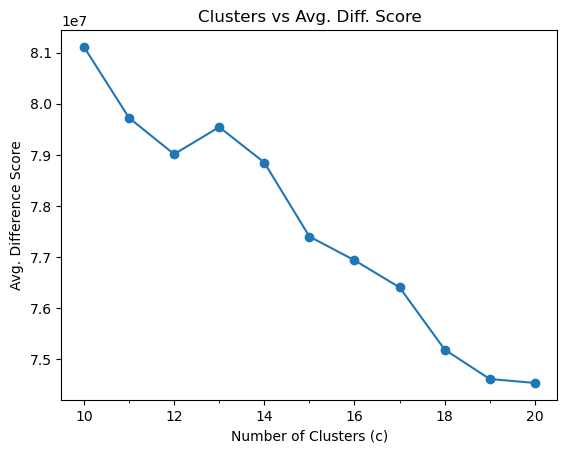

In [216]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.plot(cluster_count, scores, marker='o')
plt.xticks(cluster_count, minor=True)
plt.xlabel('Number of Clusters (c)')
plt.ylabel('Avg. Difference Score')
plt.title('Clusters vs Avg. Diff. Score')
plt.show() #plot the first set of calculated averages


In [213]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans_19 = KMeans(n_clusters=19)
model_19 = kmeans_19.fit(pca_75_data)
pred_19 = model_19.predict(pca_75_data)#Generate cluster predictions using 19 clusters on 75 components


### Discussion 3.1: Apply Clustering to General Population

#### KMeans Average Plot Assessment
The KMeans plot looks to level off between 18 and 20 clusters. For this reason, I'm selecting 19 for my KMeans cluster value.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [232]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv',delimiter=';')

In [233]:
customers.shape

(191652, 85)

In [234]:
# Apply preprocessing
cust_clean_df = clean_data(customers)

C:\Users\JeffHansberry.000\AppData\Local\Temp\ipykernel_12716\945778120.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=mixed, axis="columns", inplace=True)


In [235]:
cust_clean_df.shape

(141725, 148)

In [236]:
#Apply feature transformation to customer demographics data.
#Check for current np.nan values in our dataset (cust_clean_df)
cust_clean_df.isnull().sum().sum()

251268

In [237]:
#Use imputation to clear these np.nan values
cust_clean_imputed = imputer.transform(cust_clean_df)

In [238]:
#Check for current np.nan values post-imputation
#First, convert cust_clean_imputed back into a DataFrame for ease of use
#Create a list of cust_clean_df column names to use when converting its ndarray type back to DataFrame
cust_clean_cols = list(cust_clean_df.columns.values)

#Pass the cust_clean_imputed as 'data', and cust_clean_cols as 'columns'
cust_clean_imputed_df = pd.DataFrame(data=cust_clean_imputed, columns=cust_clean_cols)

#Now that we have a DataFrame again, check for post-imputation null values
cust_clean_imputed_df.isnull().sum().sum()

0

In [239]:
#Apply feature scaling to the customer data
cust_feature_scaled = scaler.transform(cust_clean_imputed_df)

In [240]:
#Convert cust_feature_scaled to a DataFrame for ease of use
cust_feature_scaled_df = pd.DataFrame(data=cust_feature_scaled, columns=cust_clean_cols)

#### Accounting for get_dummies and missing columns
Since I used pd.get_dummies() on the cleaned customer data, I hit an error when trying to apply PCA to the customer data. The 'GEBAEUDETYP_5.0' column wasn't created in the cust_feature_scaled_df, since a value of '5' wasn't present for get_dummies() to allocate a column for.

Therefore, I'll create the missing column and fill it with zeros, effectively representing the same level of information and allowing me to proceed.

In [244]:
#Compare columns between the general demographic data and the customer data.
#Identify the missing column
for i in lt_30.columns:
    if i not in cust_feature_scaled_df.columns:
        print(i)

GEBAEUDETYP_5.0


In [245]:
#Add the missing column to our customer dataframe and populate with zeros
#Need to add a zero in each row for this column (Total rows: 141725)
GEBAEUDETYP_5 = pd.Series(np.zeros(141725))
cust_feature_scaled_df['GEBAEUDETYP_5.0'] = GEBAEUDETYP_5

#Order the customer df columns to match the lt_30 df columns
cols = lt_30.columns.tolist()
cust_feature_scaled_df = cust_feature_scaled_df[cols]

In [248]:
#Verify adjusted shape of cust_feature_scaled_df
cust_feature_scaled_df.shape

(141725, 149)

In [250]:
#Apply PCA using pca_75 from demographic data
customers_pca_75 = pca_75.transform(cust_feature_scaled_df)

In [251]:
#Apply clustering to customer demographics data
#Use the same KMeans object as was used on demographics data
pred_cust = model_19.predict(customers_pca_75)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

### General Population and Customer Population Comparisons
For this section, I'm going to compare the prediction data generated for the general population with that of the customer population. Specifically, these datasets:
* General Population: pred_19
* Customer Population: pred_cust

In [265]:
#Convert our prediction data to DataFrames for ease of use
pred_19_df = pd.DataFrame(data=pred_19, columns=['gen_pop_preds'])
pred_cust_df = pd.DataFrame(data=pred_cust, columns=['cust_pop_preds'])

In [270]:
#Calculate the proportions for each
gen_prop = pred_19_df['gen_pop_preds'].value_counts().sort_index()/ \
           sum(pred_19_df['gen_pop_preds'].value_counts())
cust_prop = pred_cust_df['cust_pop_preds'].value_counts().sort_index()/ \
            sum(pred_cust_df['cust_pop_preds'].value_counts())

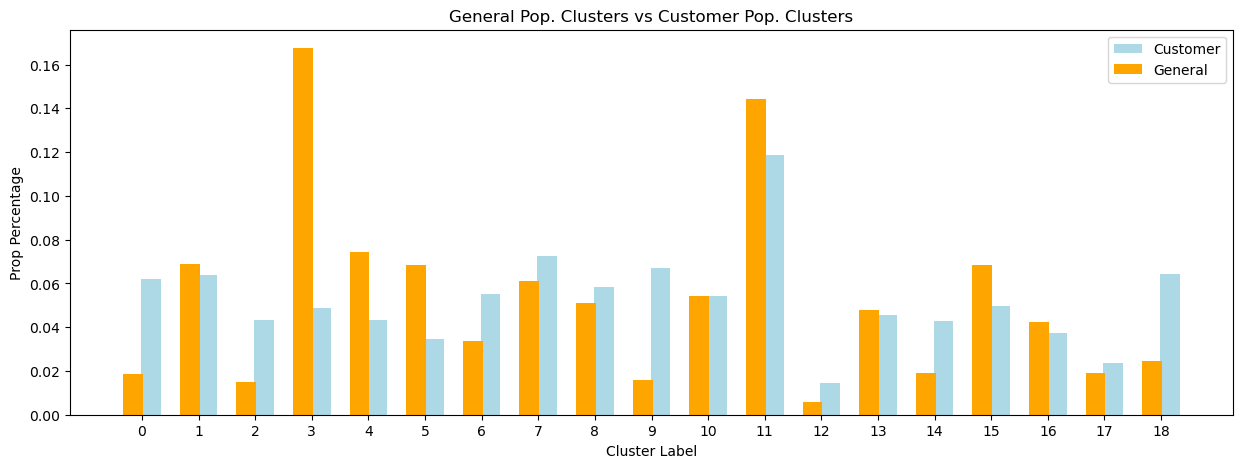

In [352]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
fig, ax = plt.subplots(figsize=(15, 5))
width = 0.35

general = ax.bar(gen_prop.index+.45*width, gen_prop, width, color='lightblue')
customer = ax.bar(cust_prop.index-.45*width, cust_prop, width, color='orange')

ax.set_ylabel('Prop Percentage')
ax.set_xlabel('Cluster Label')
ax.set_title('General Pop. Clusters vs Customer Pop. Clusters')
ax.set_xticks(cust_prop.index)
ax.legend(('Customer', 'General'))
plt.show()

To assist with visualizing the individual features associated with these clusters, below is a helper function that performs the inverse transform on our PCA data for each data set. Specifically, we'll be looking at two clusters.

* Cluster 0: Customer data is overrepresented compared to the general population
* Cluster 3: Customer data is underrepresented compared to the general population

In [353]:
# Referenced:
#https://stackoverflow.com/questions/71510257/how-to-conveniently-perform-pca-inverse-transform-on-lesser-number-of-components
#Use PCA's inverse_transform to decompose the clusters into their components
def invert_PCA_plot(df, kmeans, cluster):
    X = pd.DataFrame.from_dict(dict(zip(df.columns,
        pca.inverse_transform(kmeans.cluster_centers_[cluster]))), orient='index').rename(
        columns={0: 'feature_values'}).sort_values('feature_values', ascending=False)
    X['feature_values_abs'] = abs(X['feature_values'])
    pd.concat((X['feature_values'][:5], X['feature_values'][-5:]), axis=0).plot(kind='barh');

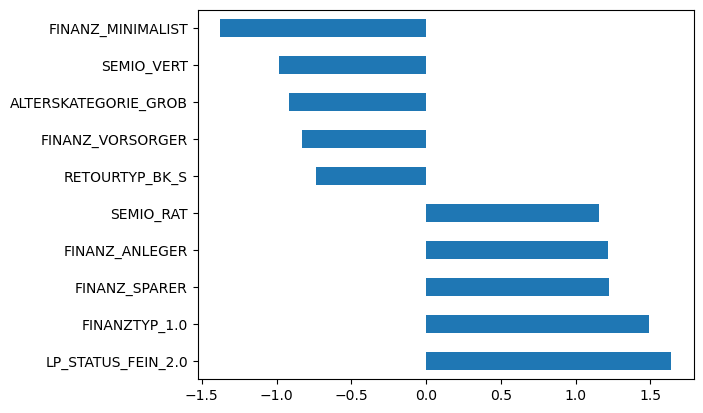

In [354]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

invert_PCA_plot(lt_30, model_19, 0)

### Cluster 0 Population Assessment
#### Negative Correlations
|Category| English Translation|
|--------|:-------------------|
|FINANZ_MINIMALIST        |Financial typology (low financial interest)
|SEMIO_VERT               |Personality typology (dreamful)
|ALTERSKATEGORIE_GROB	  |Estimated Age
|FINANZ_VORSORGER         |Financial typology (be prepared)
|RETOURTYP_BK_S           |Return type

#### Positive Correlations
|Category| English Translation|
|--------|:-------------------|
|LP_STATUS_FEIN_2.0	     |Social status (orientation-seeking low-income earners)
|FINANZTYP_1.0           |Most descriptive financial type for individual (low financial interest)
|FINANZ_SPARER           |Financial typology (money-saver)
|FINANZ_ANLEGER          |Financial typology (investor)
|SEMIO_RAT               |Personality typology (rational)

#### Assessment Summary
* Strongly influenced by orientation-seeking social status, low-income, low financial interest, money-saver, rationa, investor types
* Least influenced by low financial interest, dreamful, prepared types.

I find it interesting that 'low-financial interest' occurs in both the positive and negative correlation categories. That being said, this cluster indicates that low-income, frugal customers are a good target demographic.

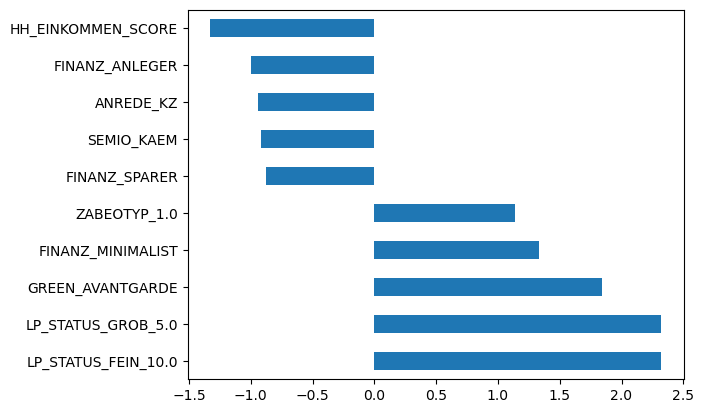

In [355]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

invert_PCA_plot(lt_30, model_19, 3)

### Cluster 3 Population Assessment
#### Negative Correlations
|Category| English Translation|
|--------|:-------------------|
|HH_EINKOMMEN_SCORE       |Estimated household net income
|FINANZ_ANLEGER           |Financial typology (investor)
|ANREDE_KZ                |Gender
|SEMIO_KAEM               |Personality typology (combative attitude)
|FINANZ_SPARER            |Financial typology (money-saver)

#### Positive Correlations
|Category| English Translation|
|--------|:-------------------|
|LP_STATUS_FEIN_10.0     |Social status, fine scale (top earners)
|LP_STATUS_GROB_5.0      |Social status, rough scale (top earners)
|GREEN_AVANTGARDE        |Membership in environmental sustainability as part of youth
|FINANZ_MINIMALIST       |Financial typology (low financial interest)
|ZABEOTYP_1.0            |Energy consumption typology (green)

#### Assessment Summary
* Strongly influenced by environmentally conscious and wealthy types.
* Least influenced by money-saver, investor types with combative attitude personalities.

This cluster indicates that wealthy, environmentally conscious individuals are not the target demographic.

### Discussion 3.3: Compare Customer Data to Demographics Data

As stated above, key takeaways based on two targeted cluster assessments indicate that those people who are low-income and frugal would make a good target demographic for the company.

However, those people who are wealthy, environmentally conscious individuals are not the target demographic for the company.

Further analysis of additional clusters would help refine and describe more demographic targeting data.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.